In [1]:
# Import library
import h5py
import numpy as np
import matplotlib.pyplot as plt 

# load data
# File name
Data_fName = 'mnist_traindata.hdf5'

# Read train data
with h5py.File(Data_fName, 'r+') as df:
    xdata = df['xdata'][:]
    ydata = df['ydata'][:]

# Train data
xdata_train = xdata[np.arange(10000,len(xdata)),:]
ydata_train = ydata[np.arange(10000,len(xdata)),:]

xdata_valid = xdata[np.arange(10000),:]
ydata_valid = ydata[np.arange(10000),:]

# File name
Data_fName = 'mnist_testdata.hdf5'

# Read test data
with h5py.File(Data_fName, 'r+') as df:
    xdata_test = df['xdata'][:]
    ydata_test = df['ydata'][:]


In [2]:
# softmax function
def softmax(data):
    z = np.exp(data - np.max(data))
    return z / z.sum(axis =1, keepdims=True)

# Activation function
def activation(data, option):
    if option == 'ReLU':
        return np.maximum(0,data)
    
    elif option == 'tanh':
        return np.tanh(data)

def activation_deri(data, option):
    if option == 'ReLU':
        return data > 0
    
    elif option == 'tanh':
        return 1.0 - np.tanh(data)**2

# Cross-entropy loss
def cross_entropy(pred, gtrue):
    return -np.sum(gtrue * np.log(pred + 1e-10)) / gtrue.shape[0]

# Derivative of cross-entropy
def cross_entropy_deri(pred, gtrue):
    return pred - gtrue

# Forward propagation
def forward_prop(data, weights, bias, option):
    # First layer
    s1 = data.dot(weights['w1']) + bias['b1']
    a1 = activation(s1, option)

    # Second layer
    s2 = a1.dot(weights['w2']) + bias['b2']
    a2 = activation(s2, option)

    # Output layer
    s3 = a2.dot(weights['w3']) + bias['b3']
    a3 = softmax(s3)

    return s1, a1, s2, a2, s3, a3

# L1 regularization
def l1_reg(weights):
    return alpha * np.sum(np.abs(weights))

# L1 derivative
def l1_reg_deri(weights):
    return alpha * np.sign(weights)

# Backward propagation
def back_prop(data, gtrue, s1, a1, s2, a2, s3, a3, weights, option):
    m = data.shape[0]

    ds3 = cross_entropy_deri(a3, gtrue)
    dw3 = a2.T.dot(ds3) / m + l1_reg_deri(weights['w3'])
    db3 = np.sum(ds3, axis=0) / m

    da2 = ds3.dot(weights['w3'].T)
    ds2 = da2 * activation_deri(s2, option)
    dw2 = a1.T.dot(ds2) / m + l1_reg_deri(weights['w2'])
    db2 = np.sum(ds2, axis=0) / m

    da1 = ds2.dot(weights['w2'].T)
    ds1 = da1 * activation_deri(s1, option)
    dw1 = data.T.dot(ds1) / m + l1_reg_deri(weights['w1'])
    db1 = np.sum(ds1, axis=0) / m

    gradients = {
        'dw1': dw1,
        'db1': db1,
        'dw2': dw2,
        'db2': db2,
        'dw3': dw3,
        'db3': db3,
    }

    return gradients

# Update parameters
def update_parameters(weights, bias, gradients, learning_rate):
    weights['w1'] -= learning_rate * gradients['dw1']
    bias['b1'] -= learning_rate * gradients['db1']
    weights['w2'] -= learning_rate * gradients['dw2']
    bias['b2'] -= learning_rate * gradients['db2']
    weights['w3'] -= learning_rate * gradients['dw3']
    bias['b3'] -= learning_rate * gradients['db3']

    return weights, bias
       
def predict(pred, gtrue):
    accuracy = ((np.argmax(pred, axis=1) == np.argmax(gtrue, axis=1)).sum()) / pred.shape[0] * 100

    return accuracy

def MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option):
    accuracy_train = []; accuracy_valid = []

    for epoch in range(epochs):
        permute = np.random.permutation(xdata_train.shape[0])
        xdata_train_shuffle = xdata_train[permute]
        ydata_train_shuffle = ydata_train[permute] 
        
        if epoch == 20:
            learning_rate /= 2

        elif epoch == 40:
            learning_rate /= 2
        
        for i in range(0, xdata_train.shape[0], batch_size):
            x_batch = xdata_train_shuffle[i:i+batch_size]
            y_batch = ydata_train_shuffle[i:i+batch_size]

            # forward propagation
            s1, a1, s2, a2, s3, a3 = forward_prop(x_batch, weights, bias, option)

            # backward propagation
            gradients = back_prop(x_batch, y_batch, s1, a1, s2, a2, s3, a3, weights, option)

            # update parameters
            weights, bias = update_parameters(weights, bias, gradients, learning_rate)

        _, _, _, _, _, output_train = forward_prop(xdata_train, weights, bias, option)

        accuracy_train = np.append(accuracy_train, predict(output_train, ydata_train))
        
        _, _, _, _, _, output_valid = forward_prop(xdata_valid, weights, bias, option)

        accuracy_valid = np.append(accuracy_valid, predict(output_valid, ydata_valid))

    return accuracy_train, accuracy_valid

# Initialize weights and biases
def initialize_parameters():
    np.random.seed(42)  # For reproducibility
    weights = {
        'w1': np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2. / input_size),
        'w2': np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2. / hidden_sizes[0]),
        'w3': np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2. / hidden_sizes[1]),
    }
    bias = {
        'b1': np.zeros(hidden_sizes[0]),
        'b2': np.zeros(hidden_sizes[1]),
        'b3': np.zeros(output_size),
    }

    return weights, bias

In [3]:
# Initialize the global parameters
input_size = xdata.shape[1]  # Number of input neurons
hidden_sizes = [200, 100]  # Number of neurons in the hidden layers
output_size = 10  # Number of output neurons
batch_size = 200  # Mini-batch size for SGD
alpha = 0.001  # L1 regularization strength
epochs = 50  # Number of epochs for training

# learning rate = 0.1, activation function: ReLU
weights, bias = initialize_parameters()
learning_rate = 0.1

accuracy_train1, accuracy_valid1 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'ReLU')

# learning rate = 0.01, activation function: ReLU
weights, bias = initialize_parameters()
learning_rate = 0.01

accuracy_train2, accuracy_valid2 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'ReLU')

# learning rate = 0.001, activation function: ReLU
weights, bias = initialize_parameters()
learning_rate = 0.001

accuracy_train3, accuracy_valid3 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'ReLU')

# learning rate = 0.1, activation function: tanh
weights, bias = initialize_parameters()
learning_rate = 0.1

accuracy_train4, accuracy_valid4 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'tanh')

# learning rate = 0.01, activation function: tanh
weights, bias = initialize_parameters()
learning_rate = 0.01

accuracy_train5, accuracy_valid5 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'tanh')

# learning rate = 0.001, activation function: tanh
weights, bias = initialize_parameters()
learning_rate = 0.001

accuracy_train6, accuracy_valid6 = MLP(xdata_train, ydata_train, xdata_valid, ydata_valid, weights, bias, learning_rate, option = 'tanh')

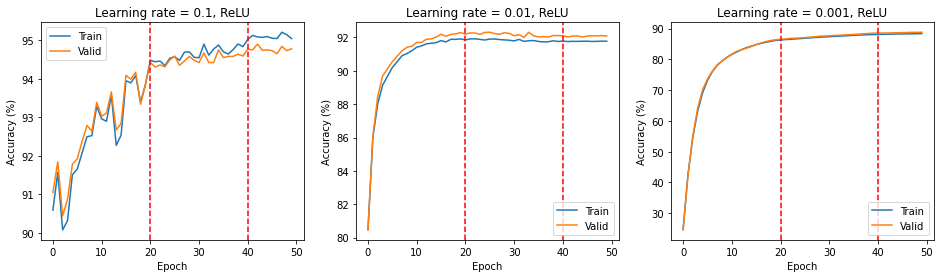

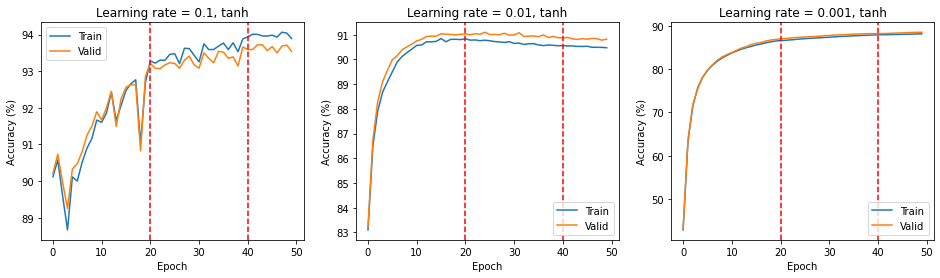

In [18]:
# Accuracy plot

fig = plt.figure(figsize = (16,4))

x = fig.add_subplot(131)  
x.plot(accuracy_train1)
x.plot(accuracy_valid1)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.1, ReLU")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

x = fig.add_subplot(132)  
x.plot(accuracy_train2)
x.plot(accuracy_valid2)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.01, ReLU")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

x = fig.add_subplot(133)  
x.plot(accuracy_train3)
x.plot(accuracy_valid3)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.001, ReLU")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

fig = plt.figure(figsize = (16,4))

x = fig.add_subplot(131)  
x.plot(accuracy_train4)
x.plot(accuracy_valid4)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.1, tanh")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

x = fig.add_subplot(132)  
x.plot(accuracy_train5)
x.plot(accuracy_valid5)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.01, tanh")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')

x = fig.add_subplot(133)  
x.plot(accuracy_train6)
x.plot(accuracy_valid6)
plt.axvline(x=20, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.axvline(x=40, color='r', linestyle='--', label=f'Epoch {epoch_point}')
plt.title("Learning rate = 0.001, tanh")
plt.legend(['Train','Valid'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.show()

In [21]:
# learning rate = 0.1, activation function: ReLU
weights, bias = initialize_parameters()
learning_rate = 0.1

# Final test accuracy for the best network
_, accuracy_test = MLP(xdata, ydata, xdata_test, ydata_test, weights, bias, learning_rate, option = 'ReLU')

In [23]:
print('Network configuration: 2 hidden layers with 200 and 100 neurons')
print('Batch size: 200')
print('Initialize parameter: He normal')
print('3 different learning rate: 0.1, 0.01, 0.001')
print('Final test accuracy using ReLU activation with 0.1 learning rate: ', accuracy_test[-1])

Network configuration: 2 hidden layers with 200 and 100 neurons
Batch size: 200
Initialize parameter: He normal
3 different learning rate: 0.1, 0.01, 0.001
Final test accuracy using ReLU activation with 0.1 learning rate:  95.11
